## CMa R1

In [4]:
import aplpy
from astropy.io import fits
%pylab inline

Populating the interactive namespace from numpy and matplotlib


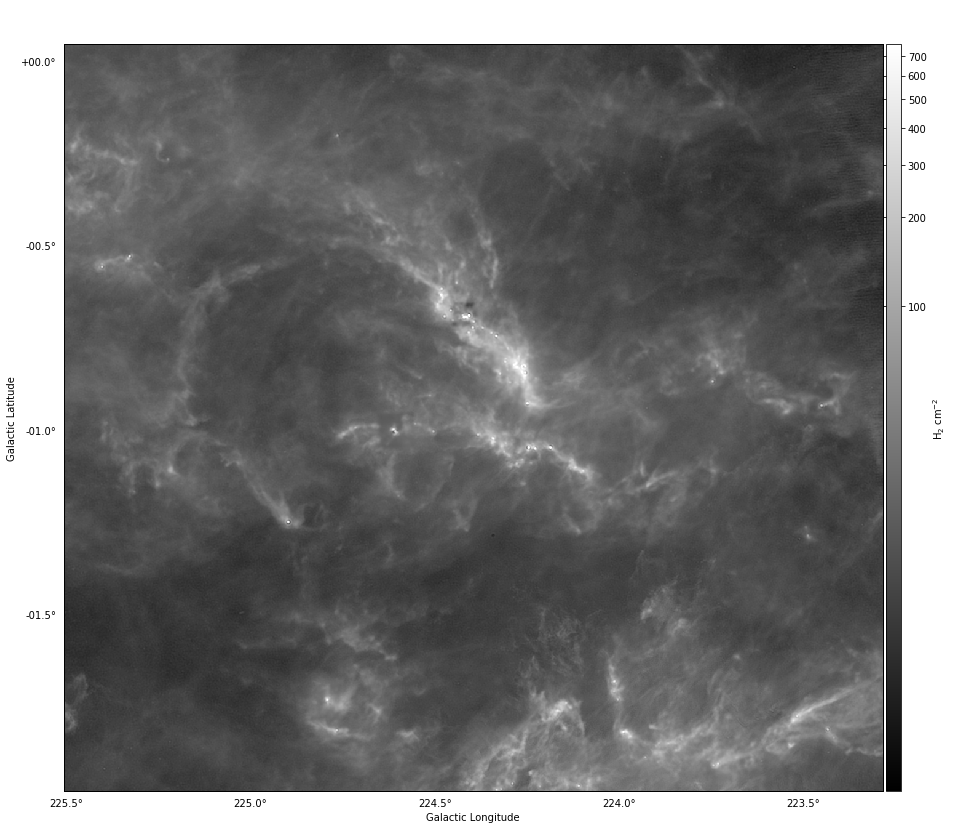

In [5]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/CMa_R1_cut_nan.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all, convention='calabretta')
fig.show_colorscale(cmap='gray',stretch='log',vmid=-1.5,vmin=0.91,vmax=766)
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.ticks.set_xspacing(0.5)  # degrees
fig.ticks.set_yspacing(0.5)  # degrees
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

In [10]:
from bokeh.plotting import figure as figbok
from bokeh.io import output_notebook
from bokeh.io import show as showbok
output_notebook()

from astropy import wcs
from powspec import powspec
from wavan import fan_trans, apodize, padding, depad
from gauss_beam import gauss_beam

Loading BokehJS ...

In [13]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [15]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

#Apodization

tapper = apodize(nb,na,0.95)
imt = imzm *tapper
imr = padding(imt,1500,1500)

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

#Beam Power spectrum
FWHM = 12. / (60.*reso)  #Beam size Ken Marsh maps
#beam = gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
beam = gauss_beam(FWHM,1500,1500,FWHM=True)
tab_k, spec_beam = powspec(beam, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation
#Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
#del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[3]

#Plot Fourier power spectrum
Tools='pan,box_zoom,reset,save,hover'
f = figbok( x_axis_label="k [arcmin^-1]", x_axis_type="log", \
           y_axis_label="P[k]", y_axis_type="log", tools=Tools, plot_width=800, plot_height=800)
f.line(tab_k, spec_k, legend='Fourier')
f.line(tab_k, spec_k/spec_beamn, color='blue', legend='Beam corrected')

#Set a list of q
q=[]
#q[0:4]=[1.4]*5
#q[5:25]=[2.5]*20
q=[2.5]*25
print q

#Wavelet power spectrum
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True)
#wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True, apodize= 0.98, arrdim = np.array([1500,1500]))

S1an = np.copy(S1a)

S1an[0,3:] = S1a[0,3:]/BS1an[3:]
S1an[1,3:] = S1a[1,3:]/BS1an[3:]
S1an[2,3:] = S1a[2,3:]/BS1an[3:]

f.diamond(wav_k, S1an[0,:], legend='Wavelet',color='black',line_width=5)
f.triangle(wav_k, S1an[1,:], legend='Coherent',color='blue',line_width=5)
f.square(wav_k, S1an[2,:], legend='Gaussian',color='red',line_width=5)

#Power law fit
coef = np.polyfit(np.log(wav_k[7:16]),np.log(S1an[2,7:16]),deg=1)
yfit = np.exp(coef[1])*wav_k**coef[0]

coef2 = np.polyfit(np.log(wav_k[11:18]),np.log(S1an[1,11:18]),deg=1)
yfit2 = np.exp(coef2[1])*wav_k**coef2[0]

print "Power law = ", coef[0],coef2[0]

f.line(wav_k, yfit, legend='Fit', line_dash='dashed')
f.line(wav_k, yfit2, line_dash='dashed')

showbok(f)

[2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5]
Power law =  -3.79250384453 -2.22397526201


In [43]:
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_Bwav_k.npy',Bwav_k)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_BS1a.npy',BS1a)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_wt.npy',wt)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_S11a.npy',S11a)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_wav_k.npy',wav_k)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_S1a.npy',S1a)
np.save('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_q.npy',q)

In [11]:
Bwav_k = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_Bwav_k.npy')
BS1a = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_BS1a.npy')
wt = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_wt.npy')
S11a = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_S11a.npy')
wav_k = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_wav_k.npy')
S1a = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_S1a.npy')
q = np.load('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_q.npy')

INFO: Auto-setting vmin to -2.983e+01 [aplpy.core]
INFO: Auto-setting vmax to  6.936e+01 [aplpy.core]
INFO: Auto-setting vmin to -6.425e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.953e+02 [aplpy.core]


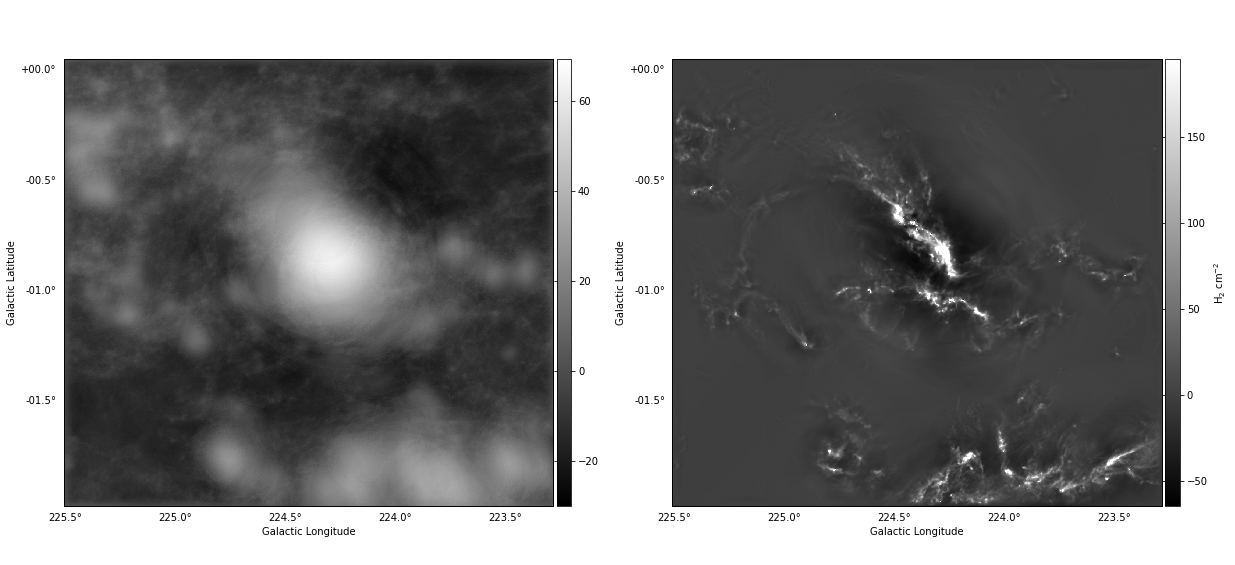

In [26]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)

fits.writeto('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_cohe.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_gaussian.fits',\
            Gaussian.real,header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,10))

figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/user/workdir/robitaij/fil2star/Herschel/Ken_Marsh/analysis/CMa_R1_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(1, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

Calcule de la PDF

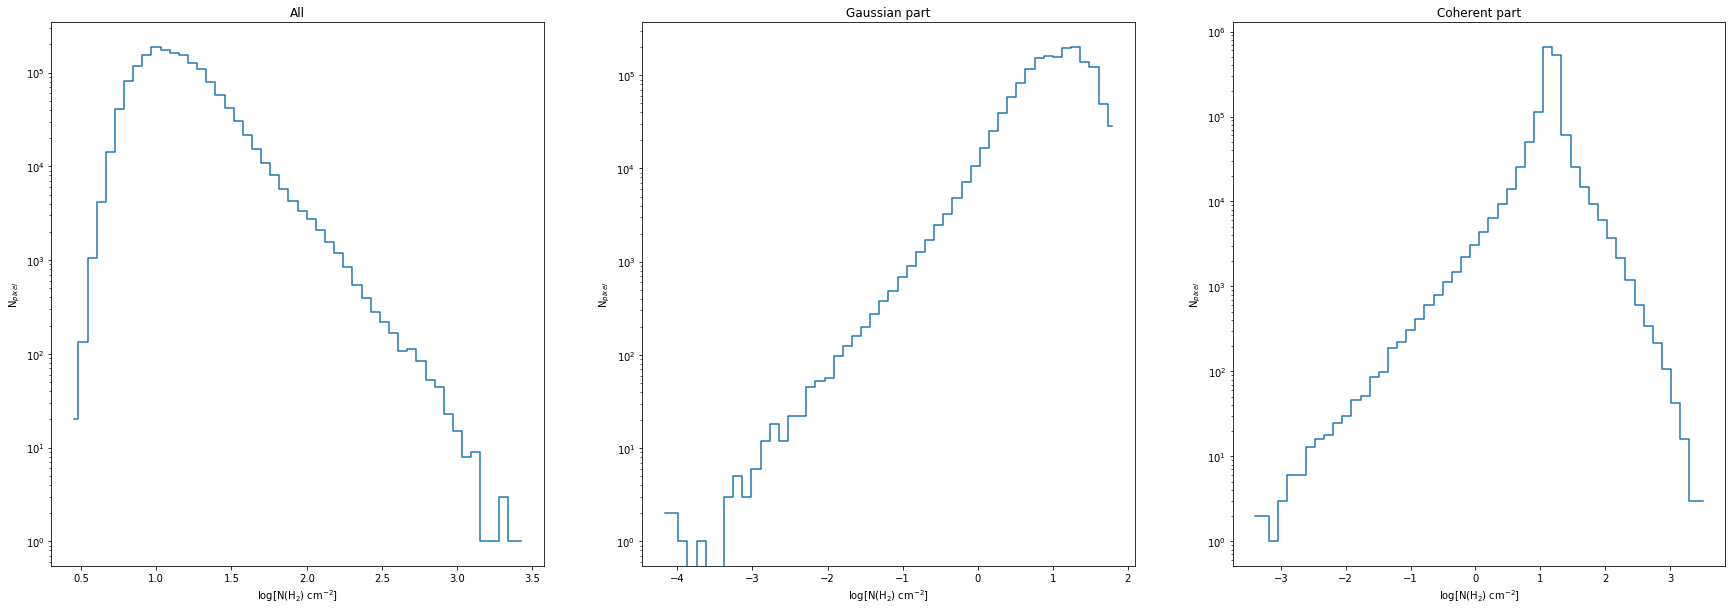

In [19]:
histo, edges = np.histogram(np.log10(im),bins=50)
histoG, edgesG = np.histogram(np.log10(Gaussian[Gaussian.real >= 0.].real),bins=50)
histoC, edgesC = np.histogram(np.log10(coherent[coherent.real >= 0.].real),bins=50)

plt.figure(1, figsize=(30,10))
plt.subplot(1,3,1)
plt.plot(edges[:-1], histo, drawstyle='steps-mid')
plt.yscale('log')
plt.ylabel(r'N$_{pixel}$')
plt.xlabel(r'log[N(H$_2$) cm$^{-2}$]')
plt.title('All')

plt.subplot(1,3,2)
plt.plot(edgesG[:-1], histoG, drawstyle='steps-mid')
plt.yscale('log')
plt.ylabel(r'N$_{pixel}$')
plt.xlabel(r'log[N(H$_2$) cm$^{-2}$]')
plt.title('Gaussian part')

plt.subplot(1,3,3)
plt.plot(edgesC[:-1], histoC, drawstyle='steps-mid')
plt.yscale('log')
plt.ylabel(r'N$_{pixel}$')
plt.xlabel(r'log[N(H$_2$) cm$^{-2}$]')
plt.title('Coherent part')

## Maps mean value & negative part

Normally, the original map should be retreived with the summation of the coherent and the Gaussian part. Could the negative regions on each map be redressed by taking some signal from the other map? A mean value for each map must be derived.

In [25]:
#Locate negative regions in coherent part

neg = np.where(coherent.real < 0.)